<a href="https://colab.research.google.com/github/Ahmed-0103/Sentiment-Analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install contractions
!pip install emoji
!pip install datasets
!pip install lime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requir

In [ ]:
import os
import numpy as np
import pandas as pd
import re
import joblib
import matplotlib.pyplot as plt
import time
from copy import deepcopy

import spacy
import emoji
from contractions import fix as fix_contractions

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, precision_score, recall_score, accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Input, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from transformers import BertTokenizer, TFBertForSequenceClassification, RobertaTokenizer, TFRobertaForSequenceClassification, create_optimizer
from datasets import Dataset

from wordcloud import WordCloud
from lime.lime_text import LimeTextExplainer

from google.colab import drive

In [ ]:
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/Ahmed_Anas_20023579_CreativePiece/')

Mounted at /content/drive


In [ ]:
twitter_df = pd.read_csv('twitter.csv', encoding = 'latin-1', header=None)

In [ ]:
reddit_df = pd.read_csv('reddit-train-balanced-sarcasm.csv')

In [ ]:
reddit_df.info()
reddit_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010771 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


label                                            comment     author  \
0      0                                         NC and NH.  Trumpbart   
1      0  You do know west teams play against west teams...  Shbshb906   
2      0  They were underdogs earlier today, but since G...   Creepeth   
3      0  This meme isn't funny none of the "new york ni...  icebrotha   
4      0                    I could use one of those tools.  cush2push   

            subreddit  score  ups  downs     date          created_utc  \
0            politics      2   -1     -1  2016-10  2016-10-16 23:55:23   
1                 nba     -4   -1     -1  2016-11  2016-11-01 00:24:10   
2                 nfl      3    3      0  2016-09  2016-09-22 21:45:37   
3  BlackPeopleTwitter     -8   -1     -1  2016-10  2016-10-18 21:03:47   
4  MaddenUltimateTeam      6   -1     -1  2016-12  2016-12-30 17:00:13   

                                      parent_comment  
0  Yeah, I get that argument. At this point, I'd ...  
1  The blazers and Mavericks (The wests 5 and 6 s...  
2                            They're favored to win.  
3                         deadass don't kill my buzz  
4  Yep can confirm I saw the tool they use for th...

In [ ]:
reddit_df.drop(columns=['author','subreddit','score', 'ups', 'downs', 'date', 'created_utc', 'parent_comment'], inplace=True)
reddit_df.dropna(inplace=True)
reddit_df.head()

label                                            comment
0      0                                         NC and NH.
1      0  You do know west teams play against west teams...
2      0  They were underdogs earlier today, but since G...
3      0  This meme isn't funny none of the "new york ni...
4      0                    I could use one of those tools.

In [ ]:
reddit_df['label'].value_counts()

label
0    505403
1    505368
Name: count, dtype: int64

In [ ]:
twitter_df.info()
twitter_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   0       1600000 non-null  int64 
 1   1       1600000 non-null  int64 
 2   2       1600000 non-null  object
 3   3       1600000 non-null  object
 4   4       1600000 non-null  object
 5   5       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


0           1                             2         3                4  \
0  0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY  _TheSpecialOne_   
1  0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY    scotthamilton   
2  0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY         mattycus   
3  0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          ElleCTF   
4  0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY           Karoli   

                                                   5  
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1  is upset that he can't update his Facebook by ...  
2  @Kenichan I dived many times for the ball. Man...  
3    my whole body feels itchy and like its on fire   
4  @nationwideclass no, it's not behaving at all....

In [ ]:
twitter_df.columns = ['label', 'id', 'date', 'query', 'user_id', 'comment']
twitter_df.drop(columns=['id', 'date', 'query', 'user_id'], inplace=True)
twitter_df.dropna(inplace=True)
twitter_df['label'] = pd.to_numeric(twitter_df['label'], errors='coerce')
twitter_df['label'] = twitter_df['label'].map({0: 0, 4: 1})
twitter_df.head()

label                                            comment
0      0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1      0  is upset that he can't update his Facebook by ...
2      0  @Kenichan I dived many times for the ball. Man...
3      0    my whole body feels itchy and like its on fire 
4      0  @nationwideclass no, it's not behaving at all....

In [ ]:
twitter_df.label.value_counts()

label
0    800000
1    800000
Name: count, dtype: int64

In [ ]:
# Load spaCy model and stopwords
nlp = spacy.load("en_core_web_sm")
stopwords = nlp.Defaults.stop_words

# Text Cleaning
def handle_negation(text):
  negation_words = ["not", "n't", "no"]
  words = text.split()
  negated = False
  result = []
  for i, word in enumerate(words):
    if word in negation_words:
      negated = True
    elif negated and word not in negation_words and not word.endswith('_NEG'):
      result.append(word + '_NEG')
      negated = False
    else:
      result.append(word)
      negated = False
  return " ".join(result)

def clean_text(text):
  text = emoji.demojize(text, delimiters=("", ""))
  text = text.lower()
  text = re.sub(r"http\S+|www\S+|https\S+", '', text)
  text = re.sub(r"@\w+|#\w+", '', text)
  text = re.sub(r"[^\w\s]", '', text)
  text = re.sub(r"\s+", ' ', text).strip()
  text = fix_contractions(text)
  doc = nlp(text)
  tokens = [token.lemma_ for token in doc if token.text not in stopwords and not token.is_space]
  processed_text = " ".join(tokens)
  processed_text = handle_negation(processed_text)
  return processed_text

def preprocess_dataframe(df, text_column):
  df[text_column] = df[text_column].astype(str).apply(clean_text)
  return df

In [ ]:
# Sarcasm Detection Model (Logistic Regression)
def train_sarcasm_model(df, model_out_path, vectorizer_out_path):
  X, y = df['comment'], df['label']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

  tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
  X_train_vec = tfidf.fit_transform(X_train)
  X_test_vec = tfidf.transform(X_test)

  clf = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')
  param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
  grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1')
  grid_search.fit(X_train_vec, y_train)
  clf_tuned = grid_search.best_estimator_
  y_pred = clf_tuned.predict(X_test_vec)
  y_pred_proba = clf_tuned.predict_proba(X_test_vec)[:, 1]

  print("Sarcasm Detection Report (Logistic Regression):")
  print(classification_report(y_test, y_pred))
  print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
  print("F1-Score:", f1_score(y_test, y_pred))
  print("AUC:", roc_auc_score(y_test, y_pred_proba))
  print("Precision:", precision_score(y_test, y_pred))
  print("Recall:", recall_score(y_test, y_pred))
  print("Best parameters:", grid_search.best_params_)

  joblib.dump(clf_tuned, model_out_path)
  joblib.dump(tfidf, vectorizer_out_path)
  return clf_tuned, tfidf, X_test, y_test, y_pred

# Sarcasm Detection Model (Naive Bayes)
def train_sarcasm_model_nb(df, model_out_path="sarcasm_model_nb.pkl", vectorizer_out_path="sarcasm_vectorizer_nb.pkl"):
  X, y = df['comment'], df['label']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

  vectorizer = CountVectorizer()
  X_train_vec = vectorizer.fit_transform(X_train)
  X_test_vec = vectorizer.transform(X_test)

  clf = MultinomialNB()
  clf.fit(X_train_vec, y_train)
  y_pred = clf.predict(X_test_vec)
  y_pred_proba = clf.predict_proba(X_test_vec)[:, 1]

  print("Sarcasm Detection Report (Naive Bayes Baseline):")
  print(classification_report(y_test, y_pred))
  print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
  print("F1-Score:", f1_score(y_test, y_pred))
  print("AUC:", roc_auc_score(y_test, y_pred_proba))
  print("Precision:", precision_score(y_test, y_pred))
  print("Recall:", recall_score(y_test, y_pred))

  joblib.dump(clf, model_out_path)
  joblib.dump(vectorizer, vectorizer_out_path)
  return clf, vectorizer, X_test, y_test, y_pred

In [ ]:
# Sentiment Analysis Model (Logistic Regression)
def train_sentiment_model(df, sarcasm_model_path=None, vectorizer_path=None, model_out_path="sentiment_model.pkl"):
  X, y = df['comment'], df['label']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

  if sarcasm_model_path and vectorizer_path:
    sarcasm_model = joblib.load(sarcasm_model_path)
    sarcasm_vectorizer = joblib.load(vectorizer_path)
    sarcasm_features = sarcasm_vectorizer.transform(X_train)
    sarcasm_preds_train = sarcasm_model.predict(sarcasm_features)
    X_train = pd.Series(sarcasm_preds_train.astype(str) + " " + X_train)
    sarcasm_features_test = sarcasm_vectorizer.transform(X_test)
    sarcasm_preds_test = sarcasm_model.predict(sarcasm_features_test)
    X_test = pd.Series(sarcasm_preds_test.astype(str) + " " + X_test)

  tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
  X_train_vec = tfidf.fit_transform(X_train)
  X_test_vec = tfidf.transform(X_test)

  clf = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')
  param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
  grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1')
  grid_search.fit(X_train_vec, y_train)
  clf_tuned = grid_search.best_estimator_
  y_pred = clf_tuned.predict(X_test_vec)
  y_pred_proba = clf_tuned.predict_proba(X_test_vec)[:, 1]

  print("Sentiment Analysis Report (Logistic Regression):")
  print(classification_report(y_test, y_pred))
  print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
  print("F1-Score:", f1_score(y_test, y_pred))
  print("AUC:", roc_auc_score(y_test, y_pred_proba))
  print("Precision:", precision_score(y_test, y_pred))
  print("Recall:", recall_score(y_test, y_pred))
  print("Best parameters:", grid_search.best_params_)

  joblib.dump(clf_tuned, model_out_path)
  joblib.dump(tfidf, model_out_path.replace(".pkl", "_vectorizer.pkl"))
  return clf_tuned, tfidf, X_test, y_test, y_pred


# Sentiment Analysis Model (Naive Bayes)
def train_sentiment_model_nb(df, sarcasm_model_path=None, vectorizer_path=None, model_out_path="sentiment_model_nb.pkl"):
  X, y = df['comment'], df['label']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

  # If sarcasm model and vectorizer provided, use sarcasm predictions as features
  if sarcasm_model_path and vectorizer_path:
    sarcasm_model = joblib.load(sarcasm_model_path)
    sarcasm_vectorizer = joblib.load(vectorizer_path)

    # Transform and predict sarcasm for train and test sets
    sarcasm_features_train = sarcasm_vectorizer.transform(X_train)
    sarcasm_preds_train = sarcasm_model.predict(sarcasm_features_train)
    X_train = pd.Series(sarcasm_preds_train.astype(str) + " " + X_train)

    sarcasm_features_test = sarcasm_vectorizer.transform(X_test)
    sarcasm_preds_test = sarcasm_model.predict(sarcasm_features_test)
    X_test = pd.Series(sarcasm_preds_test.astype(str) + " " + X_test)

  # Vectorization and model training
  vectorizer = CountVectorizer()
  X_train_vec = vectorizer.fit_transform(X_train)
  X_test_vec = vectorizer.transform(X_test)

  clf = MultinomialNB()
  clf.fit(X_train_vec, y_train)
  y_pred = clf.predict(X_test_vec)
  y_pred_proba = clf.predict_proba(X_test_vec)[:, 1]

  print("Sentiment Analysis Report (Naive Bayes with Sarcasm Feature):")
  print(classification_report(y_test, y_pred))
  print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
  print("F1-Score:", f1_score(y_test, y_pred))
  print("AUC:", roc_auc_score(y_test, y_pred_proba))
  print("Precision:", precision_score(y_test, y_pred))
  print("Recall:", recall_score(y_test, y_pred))

  joblib.dump(clf, model_out_path)
  joblib.dump(vectorizer, model_out_path.replace(".pkl", "_vectorizer.pkl"))
  return clf, vectorizer, X_test, y_test, y_pred


In [ ]:
# Sentiment Analysis Model (BERT)
def train_bert_sentiment_model(df, model_name="bert-base-uncased", model_out_path="bert_sentiment_model", epochs=3, batch_size=16, max_length=128):
  X, y = df['comment'], df['label']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

  y_train = y_train.astype(int)
  y_test = y_test.astype(int)

  tokenizer = BertTokenizer.from_pretrained(model_name)
  train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
  test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

  train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train)).shuffle(1000).batch(batch_size)
  test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_test)).batch(batch_size)

  model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
  steps_per_epoch = len(train_dataset)
  num_train_steps = steps_per_epoch * epochs
  optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=num_train_steps)

  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

  history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset)
  model.save_pretrained(model_out_path)
  tokenizer.save_pretrained(model_out_path)

  y_pred_logits = model.predict(test_dataset).logits
  y_pred = np.argmax(y_pred_logits, axis=1)

  print(f"BERT Sentiment Analysis Report:")
  print(classification_report(y_test, y_pred))
  print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
  print("F1-Score:", f1_score(y_test, y_pred))
  print("AUC:", roc_auc_score(y_test, y_pred_logits[:, 1]))
  print("Precision:", precision_score(y_test, y_pred))
  print("Recall:", recall_score(y_test, y_pred))

  return model, tokenizer, history, X_test, y_test, y_pred


#Sentiment Analysis Model (roBERTa)
def train_roberta_sentiment_model(df, model_name="roberta-base", model_out_path="roberta_sentiment_model", epochs=3, batch_size=32, max_length=128):
  # Split data
  X, y = df['comment'], df['label'].astype(int)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

  # Tokenization
  tokenizer = RobertaTokenizer.from_pretrained(model_name)
  train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
  test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

  # Prepare datasets
  train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train)).shuffle(1000).batch(batch_size)
  test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_test)).batch(batch_size)

  # Load model
  model = TFRobertaForSequenceClassification.from_pretrained(model_name, num_labels=2)

  # Optimizer setup with learning rate schedule
  steps_per_epoch = len(train_dataset)
  num_train_steps = steps_per_epoch * epochs
  optimizer, lr_schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=num_train_steps)

  # Compile model
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

  # Train the model
  history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs)

  # Save model & tokenizer
  model.save_pretrained(model_out_path)
  tokenizer.save_pretrained(model_out_path)

  # Predict and evaluate
  y_pred_logits = model.predict(test_dataset).logits
  y_pred = np.argmax(y_pred_logits, axis=1)

  print("RoBERTa Sentiment Analysis Report:")
  print(classification_report(y_test, y_pred))
  print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
  print("F1 Score:", f1_score(y_test, y_pred))
  print("AUC:", roc_auc_score(y_test, y_pred_logits[:, 1]))
  print("Precision:", precision_score(y_test, y_pred))
  print("Recall:", recall_score(y_test, y_pred))

  return model, tokenizer, history, X_test, y_test, y_pred

In [ ]:
# Sentiment Analysis (LSTM)
def train_lstm_model(df, use_sarcasm=False, sarcasm_model_path=None, vectorizer_path=None, model_out_path = "lstm_sentiment_model.keras", max_len=100, num_words=10000, embedding_dim=100, lstm_units=128, dropout_rate=0.5, epochs=10, batch_size=32, learning_rate=0.001):
  X, y = df['comment'], df['label']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

  if use_sarcasm and sarcasm_model_path and vectorizer_path:
    sarcasm_model = joblib.load(sarcasm_model_path)
    sarcasm_vectorizer = joblib.load(vectorizer_path)
    sarcasm_features = sarcasm_vectorizer.transform(X_train)
    sarcasm_preds_train = sarcasm_model.predict(sarcasm_features)
    X_train = pd.Series(sarcasm_preds_train.astype(str) + " " + X_train)
    sarcasm_features_test = sarcasm_vectorizer.transform(X_test)
    sarcasm_preds_test = sarcasm_model.predict(sarcasm_features_test)
    X_test = pd.Series(sarcasm_preds_test.astype(str) + " " + X_test)

  tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
  tokenizer.fit_on_texts(X_train)
  X_train_seq = tokenizer.texts_to_sequences(X_train)
  X_test_seq = tokenizer.texts_to_sequences(X_test)

  X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
  X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

  model = Sequential()
  model.add(Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=max_len))
  model.add(Bidirectional(LSTM(lstm_units, return_sequences=False)))
  model.add(Dropout(dropout_rate))
  model.add(Dense(1, activation='sigmoid'))

  optimizer = Adam(learning_rate=learning_rate)
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', 'precision', 'recall'])
  model.summary()

  early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

  history = model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

  model.save(model_out_path)
  joblib.dump(tokenizer, model_out_path.replace(".keras", "_tokenizer.keras"))

  y_pred_proba = model.predict(X_test_pad)
  y_pred = np.round(y_pred_proba)

  print("LSTM Learning Model Evaluation Report:")
  print(classification_report(y_test, y_pred))
  print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
  print("F1-Score:", f1_score(y_test, y_pred))
  print("AUC:", roc_auc_score(y_test, y_pred_proba))


  return model, tokenizer, history, X_test, y_test, y_pred

In [ ]:
# Qualitative Analysis
def perform_qualitative_analysis(X_test, y_test, y_pred, n=10):
  print("\nQualitative Analysis (Examples of Correct and Incorrect Predictions)")

  y_test_array = np.array(y_test)
  y_pred_array = np.array(y_pred)

  correct_indices = np.where(y_test_array == y_pred_array)[0]
  incorrect_indices = np.where(y_test_array != y_pred_array)[0]

  get_text = X_test.iloc if isinstance(X_test, pd.Series) else X_test
  get_label = y_test.iloc if isinstance(y_test, pd.Series) else y_test

  print(f"\n {min(n, len(correct_indices))} Correct Predictions")
  for i in np.random.choice(correct_indices, min(n, len(correct_indices)), replace=False):
    print(f"Actual: {get_label[i]}, Predicted: {y_pred_array[i]}, Text: {get_text[i]}")

  print(f"\n {min(n, len(incorrect_indices))} Incorrect Predictions")
  for i in np.random.choice(incorrect_indices, min(n, len(incorrect_indices)), replace=False):
    print(f"Actual: {get_label[i]}, Predicted: {y_pred_array[i]}, Text: {get_text[i]}")

def explain_with_lime(model, model_type, X_text, index=0, tokenizer=None, vectorizer=None, max_len=100):
  class_names = ['Negative', 'Positive']
  explainer = LimeTextExplainer(class_names=class_names)

  text_instance = X_text.iloc[index] if hasattr(X_text, 'iloc') else X_text[index]

  # Define prediction function based on model type
  if model_type in ['logistic_regression', 'naive_bayes']:
    def predict_fn(texts):
      X_vect = vectorizer.transform(texts)
      return model.predict_proba(X_vect)

  elif model_type in ['bert', 'roberta']:
    def predict_fn(texts):
      encodings = tokenizer(list(texts), padding=True, truncation=True, return_tensors='tf')
      outputs = model(encodings)
      probs = tf.nn.softmax(outputs.logits, axis=1).numpy()
      return probs

  elif model_type == 'lstm':
    def predict_fn(texts):
      sequences = tokenizer.texts_to_sequences(texts)
      padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
      probs = model.predict(padded)
      return np.hstack([1 - probs, probs])

  else:
    raise ValueError(f"Unsupported model_type: {model_type}")

    # Generate explanation
  explanation = explainer.explain_instance(text_instance, predict_fn, num_features=10)
  explanation.show_in_notebook(text=True)

# WordCloud
def show_wordcloud(data, title='Word Cloud', mask=None, color_map='viridis', max_words=200):
  text = ' '.join(data)
  wordcloud = WordCloud(width=800, height=400, background_color='white',
                        stopwords=stopwords, mask=mask, colormap=color_map,
                        max_words=max_words).generate(text)
  plt.figure(figsize=(15, 7.5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(title, fontsize=20)
  plt.show()

def generate_sentiment_wordclouds(df, sentiment_column='label', text_column='comment'):
  for sentiment in df[sentiment_column].unique():
      subset = df[df[sentiment_column] == sentiment][text_column]
      title = f"Word Cloud for Sentiment: {sentiment}"
      show_wordcloud(subset, title=title)

def generate_sarcasm_wordclouds(df, sarcasm_column='label', text_column='comment'):
  for label in df[sarcasm_column].unique():
      subset = df[df[sarcasm_column] == label][text_column]
      title = f"Word Cloud for Sarcasm Label: {label}"
      show_wordcloud(subset, title=title)

In [ ]:
def perform_ablation_studies_lstm(df, max_len=100, num_words=10000, embedding_dim=100, lstm_units=128, epochs=5, batch_size=32, sarcasm_model_path=None, sarcasm_vectorizer_path=None):
  results = []

  def preprocess_text(X_raw, add_sarcasm=False):
    X = deepcopy(X_raw)
    if add_sarcasm and sarcasm_model_path and sarcasm_vectorizer_path:
      sarcasm_model = joblib.load(sarcasm_model_path)
      sarcasm_vectorizer = joblib.load(sarcasm_vectorizer_path)
      sarcasm_preds = sarcasm_model.predict(sarcasm_vectorizer.transform(X))
      X = pd.Series(sarcasm_preds.astype(str) + " " + X)
    return X

  def build_and_evaluate(model_fn, label, use_sarcasm):
    # Preprocess
    X_raw, y = df['comment'], df['label']
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42, stratify=y)

    X_train = preprocess_text(X_train_raw, add_sarcasm=use_sarcasm)
    X_test = preprocess_text(X_test_raw, add_sarcasm=use_sarcasm)

    # Tokenize
    tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(X_train)
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)
    X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
    X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

    # Train
    model = model_fn()
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    start = time.time()
    model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=epochs, batch_size=batch_size, verbose=0)
    elapsed = time.time() - start

    # Evaluate
    y_probs = model.predict(X_test_pad).flatten()
    y_pred = np.round(y_probs)
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_probs)

    suffix = " (with sarcasm)" if use_sarcasm else " (baseline)"
    print(f"\n{label + suffix}")
    print(f"Time: {elapsed:.2f}s | Accuracy: {acc:.4f} | AUC: {auc:.4f}")
    print(classification_report(y_test, y_pred, digits=4))

    results.append({
        "Model": label + suffix,
        "Accuracy": acc,
        "AUC": auc,
        "Time (s)": elapsed
        })

  # Define models
  model_variants = [
      ("Baseline LSTM", lambda: Sequential([
          Embedding(num_words, embedding_dim, input_length=max_len),
          LSTM(lstm_units),
          Dense(1, activation='sigmoid')
      ])),
      ("LSTM with Dropout", lambda: Sequential([
          Embedding(num_words, embedding_dim, input_length=max_len),
          LSTM(lstm_units, dropout=0.3, recurrent_dropout=0.3),
          Dense(1, activation='sigmoid')
        ])),
      ("Bidirectional LSTM", lambda: Sequential([
          Embedding(num_words, embedding_dim, input_length=max_len),
          Bidirectional(LSTM(lstm_units)),
          Dense(1, activation='sigmoid')
      ])),
      ("LSTM without Embedding", lambda: Sequential([
          Input(shape=(max_len,)),
          Reshape((max_len, 1)),
          LSTM(lstm_units),
          Dense(1, activation='sigmoid')
      ])),
      ("LSTM with Smaller Units", lambda: Sequential([
          Embedding(num_words, embedding_dim, input_length=max_len),
          LSTM(64),
          Dense(1, activation='sigmoid')
      ]))
  ]

  # Evaluate each model with and without sarcasm
  for label, model_fn in model_variants:
      build_and_evaluate(model_fn, label, use_sarcasm=False)
      build_and_evaluate(model_fn, label, use_sarcasm=True)

  # Plot results
  results_df = pd.DataFrame(results).set_index("Model")
  results_df[["Accuracy", "AUC"]].plot(kind="bar", figsize=(12, 6), ylim=(0, 1), colormap="viridis")
  plt.title("Model Comparison: Accuracy and AUC")
  plt.ylabel("Score")
  plt.xticks(rotation=45, ha='right')
  plt.grid(True)
  plt.tight_layout()
  plt.show()

  results_df["Time (s)"].plot(kind="bar", figsize=(10, 4), color="salmon")
  plt.title("Training Time per Model")
  plt.ylabel("Seconds")
  plt.xticks(rotation=45, ha='right')
  plt.grid(True)
  plt.tight_layout()
  plt.show()

  return results_df

In [ ]:
# Preprocessing models
reddit_df_preprocessed = preprocess_dataframe(reddit_df, 'comment')
reddit_df_preprocessed.to_csv('reddit_df_preprocessed.csv', index=False)

twitter_df_preprocessed = preprocess_dataframe(twitter_df, 'comment')
twitter_df_preprocessed.to_csv('twitter_df_preprocessed.csv', index=False)

In [ ]:
reddit_df_preprocessed = pd.read_csv('reddit_df_preprocessed.csv')
twitter_df_preprocessed = pd.read_csv('twitter_df_preprocessed.csv')

In [ ]:
reddit_df_preprocessed.dropna(inplace=True)
reddit_df_preprocessed = reddit_df_preprocessed.sample(frac=1, random_state=42).reset_index(drop=True)

twitter_df_preprocessed.dropna(inplace=True)
twitter_df_preprocessed = twitter_df_preprocessed.sample(frac=1).reset_index(drop=True)

In [ ]:
#Sarcasm model (Logistic Regression/TF-IDF)
sarcasm_clf, sarcasm_tfidf, X_test_sarcasm, y_test_sarcasm, y_pred_sarcasm_lr = train_sarcasm_model(reddit_df_preprocessed, 'sarcasm_model.pkl', 'sarcasm_vectorizer.pkl')
perform_qualitative_analysis(X_test_sarcasm, y_test_sarcasm, y_pred_sarcasm_lr, n=5)

Sarcasm Detection Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.64      0.72      0.68     98937
           1       0.69      0.60      0.64    100264

    accuracy                           0.66    199201
   macro avg       0.66      0.66      0.66    199201
weighted avg       0.66      0.66      0.66    199201

Confusion Matrix:
 [[71245 27692]
 [39656 60608]]
F1-Score: 0.6428374451114741
AUC: 0.72262860709179
Precision: 0.68638731596829
Recall: 0.6044841618128142
Best parameters: {'C': 1}

Qualitative Analysis (Examples of Correct and Incorrect Predictions)

 5 Correct Predictions
Actual: 0, Predicted: 0, Text: oh god moose munch
Actual: 1, Predicted: 1, Text: wrong use youryoure poor comma placement fragment sentence douchbaggery oh yeah believe claim
Actual: 1, Predicted: 1, Text: yes work riot shitty parent get want
Actual: 1, Predicted: 1, Text: yeah black guy w conceal carry permit get let w warning clearly actually pr

In [ ]:
#Sarcasm model (Naive Bayes)
sarcasm_clf_nb, sarcasm_vectorizer_nb, X_test_sarcasm_nb, y_test_sarcasm_nb, y_pred_sarcasm_nb = train_sarcasm_model_nb(reddit_df_preprocessed, 'sarcasm_model_nb.pkl', 'sarcasm_vectorizer_nb.pkl')
perform_qualitative_analysis(X_test_sarcasm_nb, y_test_sarcasm_nb, y_pred_sarcasm_nb, n=5)

Sarcasm Detection Report (Naive Bayes Baseline):
              precision    recall  f1-score   support

           0       0.66      0.64      0.65     98937
           1       0.65      0.67      0.66    100264

    accuracy                           0.66    199201
   macro avg       0.66      0.66      0.66    199201
weighted avg       0.66      0.66      0.66    199201

Confusion Matrix:
 [[63398 35539]
 [33052 67212]]
F1-Score: 0.6621382656453957
AUC: 0.7185270390600926
Precision: 0.6541250206810639
Recall: 0.6703502752732785

Qualitative Analysis (Examples of Correct and Incorrect Predictions)

 5 Correct Predictions
Actual: 1, Predicted: 1, Text: bbut hindu sue riot game let express religion
Actual: 1, Predicted: 1, Text: good thing score ninth bullpen practically blow game right
Actual: 0, Predicted: 0, Text: turn gatorade piss fill
Actual: 1, Predicted: 1, Text: obviously obama smart trump
Actual: 1, Predicted: 1, Text: forget rudy

 5 Incorrect Predictions
Actual: 1, Predicted

In [ ]:
#Sentiment model (Logistic Regression / TF-IDF)
clf_lr, vectorizer_lr, X_test_lr, y_test_lr, y_pred_lr = train_sentiment_model(twitter_df_preprocessed, sarcasm_model_path=None, vectorizer_path=None, model_out_path="sentiment_model_lr.pkl")
perform_qualitative_analysis(X_test_lr, y_test_lr, y_pred_lr, n=5)

Sentiment Analysis Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.77      0.73      0.75    158759
           1       0.74      0.79      0.76    158793

    accuracy                           0.76    317552
   macro avg       0.76      0.76      0.76    317552
weighted avg       0.76      0.76      0.76    317552

Confusion Matrix:
 [[116039  42720]
 [ 34033 124760]]
F1-Score: 0.7647583465380219
AUC: 0.83922962471736
Precision: 0.7449247671363745
Recall: 0.785676950495299
Best parameters: {'C': 10}

Qualitative Analysis (Examples of Correct and Incorrect Predictions)

 5 Correct Predictions
Actual: 0, Predicted: 0, Text: rain today sun
Actual: 0, Predicted: 0, Text: crick neck proper use word crick turn rite leave cool
Actual: 0, Predicted: 0, Text: fall bunkbed head try save pillow realy hurt
Actual: 0, Predicted: 0, Text: higgghhly upset ampamp somebody need start love see sexy pretty like
Actual: 0, Predicted: 0, Text: hope

In [ ]:
#Sentiment model with sarcasm (Logistic Regression / TF-IDF)
clf_lr_sarc, vectorizer_lr_sarc, X_test_lr_sarc, y_test_lr_sarc, y_pred_lr_sarc = train_sentiment_model(twitter_df_preprocessed, sarcasm_model_path="sarcasm_model.pkl", vectorizer_path="sarcasm_vectorizer.pkl", model_out_path="sentiment_model_lr_sarcasm.pkl")
perform_qualitative_analysis(X_test_lr_sarc, y_test_lr_sarc, y_pred_lr_sarc, n=5)

Sentiment Analysis Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.77      0.73      0.75    158759
           1       0.75      0.78      0.76    158793

    accuracy                           0.76    317552
   macro avg       0.76      0.76      0.76    317552
weighted avg       0.76      0.76      0.76    317552

Confusion Matrix:
 [[116211  42548]
 [ 34317 124476]]
F1-Score: 0.7640853608006949
AUC: 0.8396526840804941
Precision: 0.7452581664910432
Recall: 0.7838884585592564
Best parameters: {'C': 100}

Qualitative Analysis (Examples of Correct and Incorrect Predictions)

 5 Correct Predictions
Actual: 0, Predicted: 0, Text: 0 get intense burn hair straightener
Actual: 0, Predicted: 0, Text: 0 beautiful sunny day flto bad spend clean
Actual: 0, Predicted: 0, Text: 0 sad let people love regardless sexual orientation
Actual: 1, Predicted: 1, Text: 0 reach miller high life
Actual: 1, Predicted: 1, Text: 1 hard work pay

 5 Incorr

In [ ]:
# Sentiment model (Naive Bayes)
clf_nb, vectorizer_nb, X_test_nb, y_test_nb, y_pred_nb = train_sentiment_model_nb(twitter_df_preprocessed, model_out_path="sentiment_model_nb.pkl")
perform_qualitative_analysis(X_test_nb, y_test_nb, y_pred_nb, n=5)

Sentiment Analysis Report (Naive Bayes with Sarcasm Feature):
              precision    recall  f1-score   support

           0       0.75      0.77      0.76    158759
           1       0.76      0.75      0.76    158793

    accuracy                           0.76    317552
   macro avg       0.76      0.76      0.76    317552
weighted avg       0.76      0.76      0.76    317552

Confusion Matrix:
 [[121470  37289]
 [ 39816 118977]]
F1-Score: 0.7552680609028785
AUC: 0.8317354761738506
Precision: 0.7613748352168738
Recall: 0.7492584685722923

Qualitative Analysis (Examples of Correct and Incorrect Predictions)

 5 Correct Predictions
Actual: 0, Predicted: 0, Text: wait people hand make sad person
Actual: 0, Predicted: 0, Text: make 10000 time jealous
Actual: 1, Predicted: 1, Text: thanks look look long get get ya dig
Actual: 0, Predicted: 0, Text: ugh sleep tooth amp nose hurt soooo bad
Actual: 0, Predicted: 0, Text: nope play injure save effort goal manage play 15 min

 5 Incorre

In [ ]:
#Sentiment model with sarcasm (Naive Bayes)
clf_nb_sarc, vectorizer_nb_sarc, X_test_nb_sarc, y_test_nb_sarc, y_pred_nb_sarc = train_sentiment_model_nb(twitter_df_preprocessed, sarcasm_model_path="sarcasm_model_nb.pkl", vectorizer_path="sarcasm_vectorizer_nb.pkl", model_out_path="sentiment_nb_sarcasm.pkl")
perform_qualitative_analysis(X_test_nb_sarc, y_test_nb_sarc, y_pred_nb_sarc, n=5)

Sentiment Analysis Report (Naive Bayes with Sarcasm Feature):
              precision    recall  f1-score   support

           0       0.75      0.77      0.76    158759
           1       0.76      0.75      0.76    158793

    accuracy                           0.76    317552
   macro avg       0.76      0.76      0.76    317552
weighted avg       0.76      0.76      0.76    317552

Confusion Matrix:
 [[121470  37289]
 [ 39816 118977]]
F1-Score: 0.7552680609028785
AUC: 0.8317354761738506
Precision: 0.7613748352168738
Recall: 0.7492584685722923

Qualitative Analysis (Examples of Correct and Incorrect Predictions)

 5 Correct Predictions
Actual: 0, Predicted: 0, Text: 0 currently mcdothat fillet o fish lunch rindu mcdo stwangsa
Actual: 1, Predicted: 1, Text: 0 tried true routine home dinner watch movie sleep
Actual: 1, Predicted: 1, Text: 0 happy pretty outside today
Actual: 1, Predicted: 1, Text: 0 retweet
Actual: 1, Predicted: 1, Text: 0 fun typing site

 5 Incorrect Predictions
Act

In [ ]:
#Reduce dataset to 5% of size (40,000 rows)
twitter_df_preprocessed = twitter_df_preprocessed.sample(frac=0.05, random_state=42).reset_index(drop=True)

In [ ]:
# Deep Learning sentiment model (BERT)
with tf.device('/GPU:0'):
  bert_model, bert_tokenizer, bert_history, X_test_bert, y_test_bert, y_pred_bert = train_bert_sentiment_model(twitter_df_preprocessed, model_out_path='bert_sentiment_model')
  perform_qualitative_analysis(X_test_bert, y_test_bert, y_pred_bert, n=5)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
1985/1985 [==============================] - 870s 416ms/step - loss: 0.5380 - accuracy: 0.7278 - val_loss: 0.5008 - val_accuracy: 0.7545
Epoch 2/3
1985/1985 [==============================] - 819s 413ms/step - loss: 0.4362 - accuracy: 0.8010 - val_loss: 0.5264 - val_accuracy: 0.7546
Epoch 3/3
497/497 [==============================] - 50s 93ms/step
BERT Sentiment Analysis Report:
              precision    recall  f1-score   support

           0       0.75      0.74      0.75      3958
           1       0.75      0.76      0.75      3981

    accuracy                           0.75      7939
   macro avg       0.75      0.75      0.75      7939
weighted avg       0.75      0.75      0.75      7939

Confusion Matrix:
 [[2943 1015]
 [ 970 3011]]
F1-Score: 0.7520919195703759
AUC: 0.8289348508497728
Precision: 0.7478887232985594
Recall: 0.7563426274805325

Qualitative Analysis (Examples of Correct and Incorrect Predictions)

 5 Correct Predictions
Actual: 1, Predicted: 1, Text:

In [ ]:
# Deep Learning sentiment model (roBERTa)
with tf.device('/GPU:0'):
  roberta_model, roberta_tokenizer, roberta_history, X_test_roberta, y_test_roberta, y_pred_roberta = train_roberta_sentiment_model(twitter_df_preprocessed, model_name="roberta-base", model_out_path="roberta_sentiment_model", epochs=3, batch_size=16, max_length=128)
  perform_qualitative_analysis(X_test_roberta, y_test_roberta, y_pred_roberta, n=5)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/3
1985/1985 [==============================] - 895s 431ms/step - loss: 0.5476 - accuracy: 0.7171 - val_loss: 0.5003 - val_accuracy: 0.7585
Epoch 2/3
1985/1985 [==============================] - 850s 428ms/step - loss: 0.4771 - accuracy: 0.7710 - val_loss: 0.5080 - val_accuracy: 0.7605
Epoch 3/3
497/497 [==============================] - 72s 138ms/step
RoBERTa Sentiment Analysis Report:
              precision    recall  f1-score   support

           0       0.77      0.76      0.76      3958
           1       0.76      0.77      0.77      3981

    accuracy                           0.76      7939
   macro avg       0.76      0.76      0.76      7939
weighted avg       0.76      0.76      0.76      7939

Confusion Matrix:
 [[3006  952]
 [ 915 3066]]
F1 Score: 0.7665958244780597
AUC: 0.8435295673651463
Precision: 0.7630662020905923
Recall: 0.7701582516955539

Qualitative Analysis (Examples of Correct and Incorrect Predictions)

 5 Correct Predictions
Actual: 0, Predicted: 0, T

In [ ]:
# Deep Learning sentiment model (LSTM)
with tf.device('GPU:0'):
  lstm_model, lstm_tokenizer, lstm_history, X_test_lstm, y_test_lstm, y_pred_lstm = train_lstm_model(twitter_df_preprocessed, model_out_path = "lstm_sentiment_model.keras")
  perform_qualitative_analysis(X_test_lstm, y_test_lstm, y_pred_lstm, n=5)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
993/993 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.6389 - loss: 0.6146 - precision: 0.6320 - recall: 0.6785 - val_accuracy: 0.7318 - val_loss: 0.5293 - val_precision: 0.7240 - val_recall: 0.7518
Epoch 2/10
993/993 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.7829 - loss: 0.4670 - precision: 0.7787 - recall: 0.7926 - val_accuracy: 0.7269 - val_loss: 0.5328 - val_precision: 0.7459 - val_recall: 0.6908
Epoch 3/10
993/993 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.8200 - loss: 0.4053 - precision: 0.8185 - recall: 0.8270 - val_accuracy: 0.7182 - val_loss: 0.5703 - val_precision: 0.7125 - val_recall: 0.7345
Epoch 4/10
993/993 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.8486 - loss: 0.3363 - precision: 0.8505 - recall: 0.8478 - val_accuracy: 0.7128 - val_loss: 0.7023 - val_precision: 0.6978 - val_recall: 0.7536
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
LSTM Learning Model Evaluation Report:
              precision    recall  f1-score   support

           0     

In [ ]:
# Deep Learning sentiment model with sarcasm (LSTM)
with tf.device('GPU:0'):
  lstm_model_sarc, lstm_tokenizer_sarc, lstm_history_sarc, X_test_lstm_sarc, y_test_lstm_sarc, y_pred_lstm_sarc = train_lstm_model(twitter_df_preprocessed, use_sarcasm=True, sarcasm_model_path='sarcasm_model.pkl', vectorizer_path='sarcasm_vectorizer.pkl', model_out_path='lstm_sentiment_sarc_model.h5')
  perform_qualitative_analysis(X_test_lstm_sarc, y_test_lstm_sarc, y_pred_lstm_sarc, n=5)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
993/993 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.6429 - loss: 0.6346 - precision: 0.6383 - recall: 0.6491 - val_accuracy: 0.7330 - val_loss: 0.5282 - val_precision: 0.7186 - val_recall: 0.7684
Epoch 2/10
993/993 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.7824 - loss: 0.4679 - precision: 0.7759 - recall: 0.7911 - val_accuracy: 0.7311 - val_loss: 0.5525 - val_precision: 0.7392 - val_recall: 0.7164
Epoch 3/10
993/993 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - accuracy: 0.8150 - loss: 0.4102 - precision: 0.8115 - recall: 0.8219 - val_accuracy: 0.7275 - val_loss: 0.5661 - val_precision: 0.7237 - val_recall: 0.7388
Epoch 4/10
993/993 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8483 - loss: 0.3404 - precision: 0.8444 - recall: 0.8516 - val_accuracy: 0.7172 - val_loss: 0.6116 - val_precision: 0.7104 - val_recall: 0.7362


249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
LSTM Learning Model Evaluation Report:
              precision    recall  f1-score   support

           0       0.75      0.70      0.72      3958
           1       0.72      0.77      0.74      3981

    accuracy                           0.73      7939
   macro avg       0.73      0.73      0.73      7939
weighted avg       0.73      0.73      0.73      7939

Confusion Matrix:
 [[2760 1198]
 [ 922 3059]]
F1-Score: 0.7426559844622481
AUC: 0.8128116194673563

Qualitative Analysis (Examples of Correct and Incorrect Predictions)

 5 Correct Predictions
Actual: 0, Predicted: [0.], Text: 1 let sunshinefinally bad get class day
Actual: 1, Predicted: [0.], Text: 0 aw okay ill monday thanku miss xx
Actual: 0, Predicted: [0.], Text: 0 want pollo loco
Actual: 0, Predicted: [0.], Text: 0 get ready skewl tired crap mschelseababylt3
Actual: 1, Predicted: [1.], Text: 0 awesome love draw hope hope come soon holland

 5 Incorrect Predictions
Actual: 0, Predi

In [ ]:
with tf.device('GPU:0'):
  perform_ablation_studies_lstm(twitter_df_preprocessed)

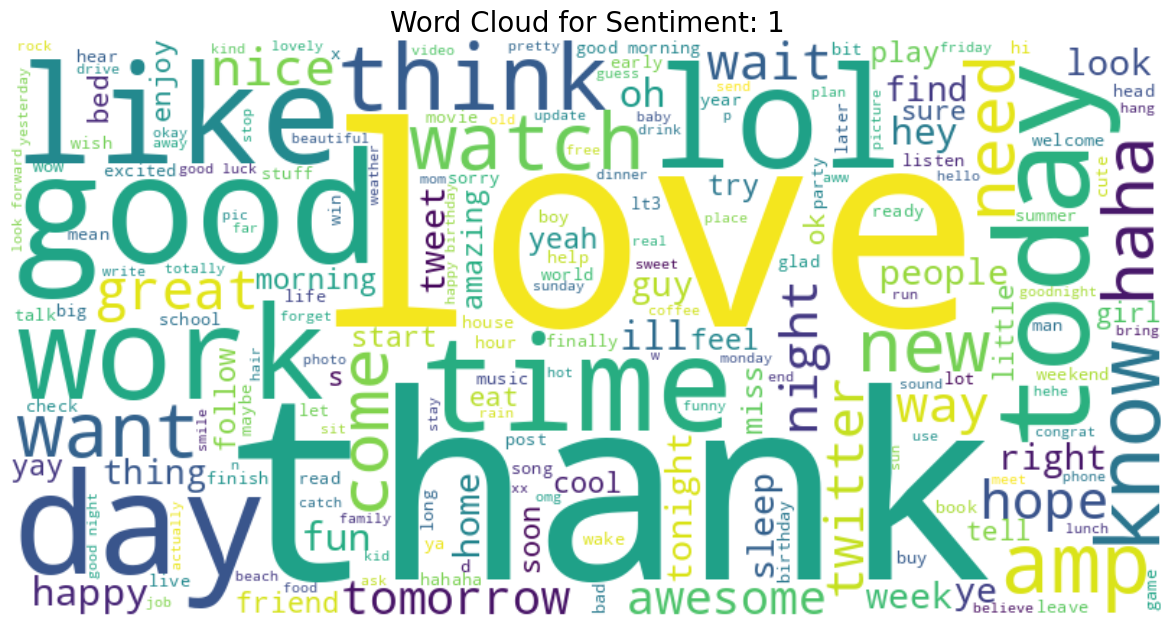

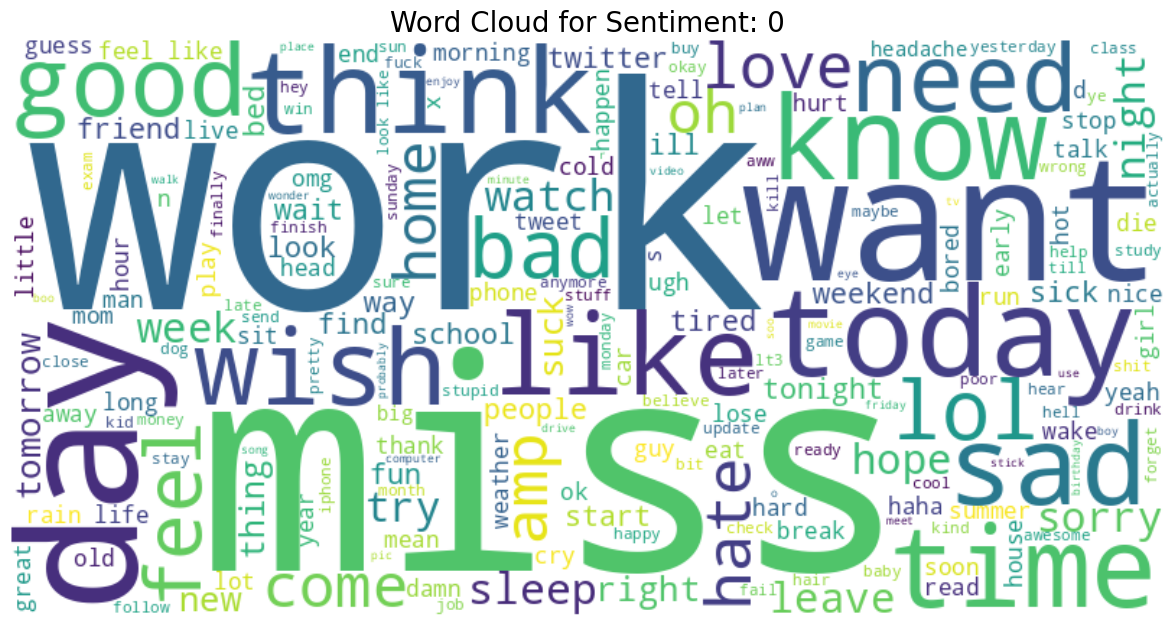

In [ ]:
# Word Clouds
generate_sentiment_wordclouds(twitter_df_preprocessed, sentiment_column='label', text_column='comment')

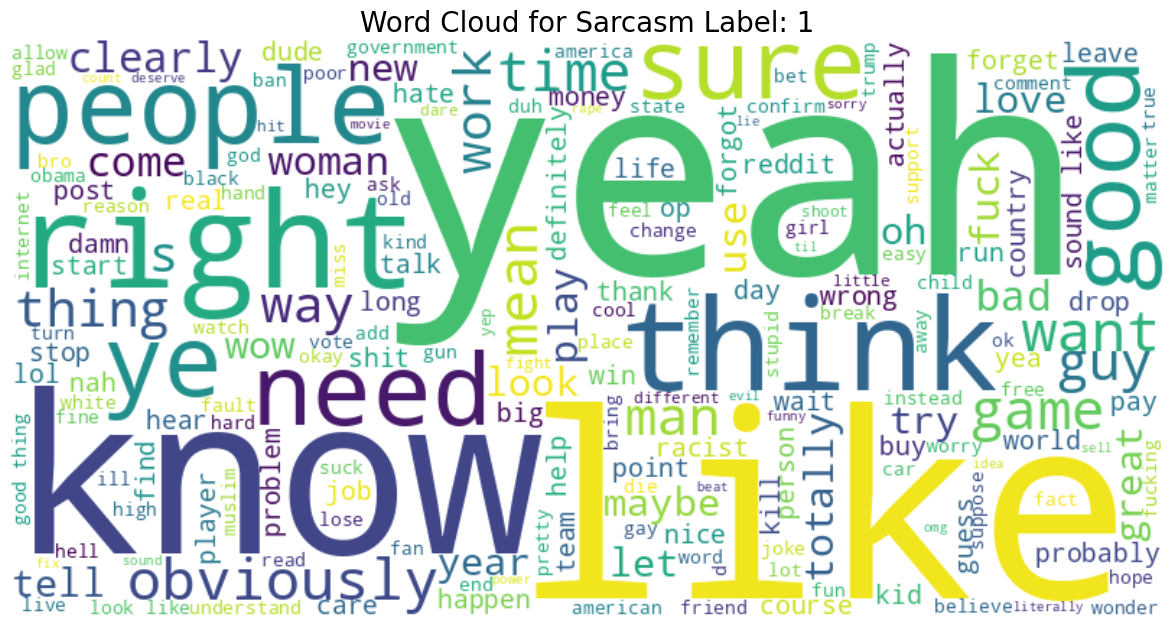

In [ ]:
generate_sarcasm_wordclouds(reddit_df_preprocessed, sarcasm_column='label', text_column='comment')

In [ ]:
clf_lr = joblib.load("sentiment_model_lr.pkl")
vectorizer_lr = joblib.load("sentiment_model_lr_vectorizer.pkl")

lstm_model = load_model("lstm_sentiment_model.keras")
lstm_tokenizer = joblib.load("lstm_sentiment_model_tokenizer.keras")

bert_model = TFBertForSequenceClassification.from_pretrained("bert_sentiment_model")
bert_tokenizer = BertTokenizer.from_pretrained("bert_sentiment_model")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at bert_sentiment_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [ ]:
# Logistic Regression
explain_with_lime(model=clf_lr,model_type='logistic_regression', X_text=X_test_lr, index=3, vectorizer=vectorizer_lr)

# BERT
explain_with_lime(model=bert_model, model_type='bert', X_text=X_test_bert, index=1, tokenizer=bert_tokenizer)

# LSTM
explain_with_lime(model=lstm_model, model_type='lstm', X_text=X_test_lstm, index=1, tokenizer=lstm_tokenizer, max_len=100)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [ ]:
test_comments = ["I love this product!", "Oh wow, another delay. Just what I needed."]

In [ ]:
X_vec = vectorizer_lr.transform(test_comments)
lr_preds = clf_lr.predict(X_vec)
print("Logistic Regression predictions:", lr_preds)

Logistic Regression predictions: [1 0]


In [ ]:
inputs_bert = bert_tokenizer(test_comments, padding=True, truncation=True, max_length=128, return_tensors='tf')
outputs_bert = bert_model(inputs_bert)
bert_preds = tf.argmax(outputs_bert.logits, axis=1).numpy()
print("BERT predictions:", bert_preds)

BERT predictions: [1 1]


In [ ]:
seqs = lstm_tokenizer.texts_to_sequences(test_comments)
padded = pad_sequences(seqs, maxlen=100, padding='post', truncating='post')

# Predict
lstm_probs = lstm_model.predict(padded)
lstm_preds = (lstm_probs > 0.5).astype(int).flatten()
print("LSTM predictions:", lstm_preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
LSTM predictions: [1 1]
